# DESARROLLO DE MODELOS PREDICTIVOS PARA LA CLASIFICACIÓN DE RIESGOS CREDITICIOS

En este notebook se presentarán las implementaciones de los 4 modelos predictivos propuestos en el paper "":
- Árbol de decisión CART
- Random Forest
- K-Nearest Neighbors
- Neural Networks

## ESTRUCTURA
Este trabajo se estructurará de acuerdo a las fases descritas en el framework CRISP DM:
1. Comprensión del negocio
2. Comprensión de los datos
3. Preparación de los datos
4. Modelado
5. Evaluación
6. ~~Despliegue (ausente)~~


## 1. COMPRENSIÓN DEL NEGOCIO

En los servicios financieros, específicamente en la atención a una solicitud de crédito para un fin específico, es necesaria la evaluación del solicitante para determinar si este podrá cancelar las cuotas o deudas que conlleva el crédito. Para ello, las entidades financieras se basan en 5 factores: Carácter, Capacidad, Capital, Colateral, Condiciones.

Estos cinco factores indican la estabilidad laboral del solicitante por medio de antecedentes, si posee solvencia económica para pagar el préstamo (proporción entre deudas e ingresos), la diferencia entre sus valores activos y pasivos, los activos que pueden ser expropiados si no cumple con el pago, y las circunstancias externas que puedan afectar la situación financiera del solicitante. Cabe aclarar que estos 5 factores son básicos para una evaluación, por lo que las entidades pueden aumentar y modificar factores para una evaluación más exhaustiva.

En este caso, solo se cuenta con data de 9 atributos de los solicitantes, por lo que no se podrá suplir las 5 Cs detalladas en su totalidad, pero sí se podrá observar cuáles de estos 9 atributos son los que influyen más en la decisión de clasificar a un solicitante como Riesgo Bueno o Riesgo Malo, y relacionarlos con los 5 factores descritos.

### OBJETIVOS

El objetivo de este trabajo es el de implementar 4 modelos predictivos de clasificación, evaluarlos con métricas para clasificación y comparar los resultados para determinar cuáles de estos cuatro puede ser utilizado como predictor en la evaluación de riesgos crediticios.

Además, se identificarán cuáles han sido los atributos más influyentes y confirmar que estos se basan en los 5 factores detallados.

## 2. COMPRENSIÓN DE LOS DATOS

### RECOPILACIÓN

La data utilizada para este trabajo proviene de [...], pero se está trabajando con una derivada de ..., ya que esta última presenta solo los atributos realmente útiles. Es decir, ya se ha realizado un preprocesamiento de la data en cuestión de la selección de los atributos en base al criterio de ... .

### COMPOSICIÓN

Se procede a analizar la data en base a sus atributos y a las 1000 observaciones:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv( 'data/german_credit_data.csv', index_col=0)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
#Número de filas y columnas
data.shape

(1000, 10)

In [5]:
#Tipo de datos en la tabla
data.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

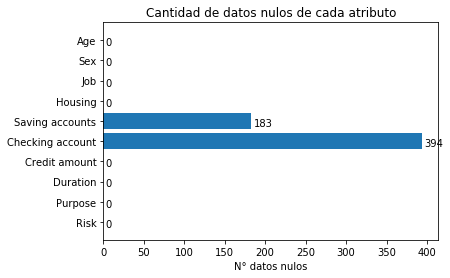

In [25]:
#Cantidad de datos nulos en las columnas

fig, ax = plt.subplots()
x_null, y_null = data.columns, data.isna().sum()

ax.barh(x_null, y_null)
ax.set_title("Cantidad de datos nulos de cada atributo")
ax.invert_yaxis()
ax.set_xlabel("N° datos nulos")
for i, v in enumerate(y_null):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='regular')

plt.show()

#### INFORMACIÓN ÚNICA EN COLUMNAS DE DATOS DISCRETOS
Se presentan todas las columnas que son de tipo `object`:

In [50]:
# información única en las columnas de datos discretos
for col in data.select_dtypes(include="object"):
    print(f"{col:16}: ", end=""), print(*(data[col].unique()), sep=", ")

Sex             : male, female
Housing         : own, free, rent
Saving accounts : nan, little, quite rich, rich, moderate
Checking account: little, moderate, nan, rich
Purpose         : radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others
Risk            : good, bad


__OBSERVACIÓN:__ A pesar de que no se presentan los datos nulos como únicos, se puede apreciar que en las columnas `Housing` y `Saving accounts` presentan el dato único `nan`, lo que indicaría que las columnas podrían alvergar otro formato de indicar que sus observaciones presentan datos nulos.

Analizamos entonces toda la data entera, y se puede apreciar que el atributo `Job`, a pesar de no ser de tipo `object`, presenta 4 valores únicos. Esto se debe a que ... *EXPLICAR*.

In [44]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

#### BALANCE DE CLASES EN TARGET

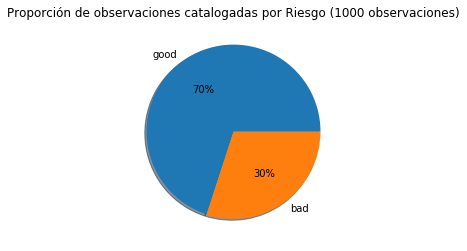

In [61]:
fig, ax = plt.subplots()
ax.pie(data['Risk'].value_counts(), autopct="%.0f%%", labels=data["Risk"].unique(), shadow=True)
ax.set_title("Proporción de observaciones catalogadas por Riesgo (1000 observaciones)")
plt.show()

## 2. PREPARACIÓN DE LOS DATOS
### Se completarán los datos vacíos con la moda
Se halla la moda de Saving accounts y Checking account

In [10]:
import statistics as stats

stats.mode(data['Saving accounts'])

'little'

In [11]:
data_ca = data['Checking account'].dropna()
stats.mode(data_ca)


'little'

In [12]:
data_completed = data.fillna('little')
data_completed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## 2. Transformación de datos cualitativos a cuantitativos

In [13]:
from sklearn import preprocessing
def encode_features(data_T):
    features = ['Sex', 'Housing','Saving accounts','Checking account','Purpose', 'Risk']

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(data_T[feature])
        data_T[feature] = le.transform(data_T[feature])

    return data_T
    
data_processed = encode_features(data_completed)
data_processed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,0,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


In [14]:
data_processed.dtypes

Age                 int64
Sex                 int32
Job                 int64
Housing             int32
Saving accounts     int32
Checking account    int32
Credit amount       int64
Duration            int64
Purpose             int32
Risk                int32
dtype: object

## 3. Separación en entrenamiento y en validación

In [15]:
from sklearn.model_selection import train_test_split


x = data_processed.drop('Risk',axis=1)
y = data_processed['Risk']

num_test = 0.20
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=num_test)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')


Train shape     : (800, 9)
Validation shape: (200, 9)


## 4. Modelos de Entrenamiento

### Primer modelo: Árbol de Decisión

In [16]:
from sklearn.tree import DecisionTreeClassifier #máxima profundidad es 26
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=8)
dtc.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
dtc.score(x_train, y_train)

0.82375

In [18]:
dtc.score(x_val, y_val)


0.655

### Segundo modelo: Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=50, n_jobs=-1, warm_start=True)
rfc.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [20]:
rfc.score(x_train, y_train)

0.92375

In [21]:
rfc.score(x_val, y_val)

0.725

#### Usando KFold

In [22]:
from sklearn.model_selection import KFold
NSplits = 10
kf = KFold(n_splits=NSplits)
kf.get_n_splits(x)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [23]:
from sklearn import metrics

In [24]:
AccTotal = 0

for train_index, test_index in kf.split(x):
    X_train, X_test = x.values[train_index], x.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    
    rfcl = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=50, n_jobs=-1, warm_start=True, random_state=0)
    rfcl.fit(X_train, Y_train)

    Y_pred = rfcl.predict(X_test)
    AccFolder = metrics.accuracy_score(Y_test, Y_pred)*100
    print("Accuracy Folder", AccFolder)
  
    AccTotal += AccFolder
  
print("Accuracy General:", AccTotal/NSplits)


Accuracy Folder 81.0
Accuracy Folder 68.0
Accuracy Folder 78.0
Accuracy Folder 76.0
Accuracy Folder 75.0
Accuracy Folder 63.0
Accuracy Folder 73.0
Accuracy Folder 75.0
Accuracy Folder 70.0
Accuracy Folder 70.0
Accuracy General: 72.9


### Tercer Modelo: KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 18, p=3)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_val)
print(metrics.accuracy_score(y_val,y_pred)*100)


70.5


### Cuarto Modelo: Redes Neuronales

In [88]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (100,),solver='sgd', learning_rate='adaptive')
mlp.fit(x_train, y_train)    

print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_val, y_val))


Training set score: 0.691250
Test set score: 0.735000


## Características más importantes

### Árbol de decisión

In [381]:
columnsNames = data.columns.values
listOfColumnNames = list(columnsNames)

for feature in zip(listOfColumnNames, dtc.feature_importances_):
    print(feature)

('Age', 0.18947256184974318)
('Sex', 0.007757241442696397)
('Job', 0.050646120681734096)
('Housing', 0.08496466128453149)
('Saving accounts', 0.041621492235041864)
('Checking account', 0.03242567838939556)
('Credit amount', 0.34561915255006725)
('Duration', 0.1736143669672264)
('Purpose', 0.07387872459956382)


In [382]:
from sklearn.feature_selection import SelectFromModel

select_featuresDT = SelectFromModel(dtc, threshold=0.09)
select_featuresDT.fit(x_train, y_train)

for feature_list_index in select_featuresDT.get_support(indices=True):
    print(listOfColumnNames[feature_list_index])

Age
Credit amount
Duration


### Random Forest

In [383]:
for feature in zip(listOfColumnNames, rfc.feature_importances_):
    print(feature)

('Age', 0.1953912034899732)
('Sex', 0.036290389822295044)
('Job', 0.06066254041826068)
('Housing', 0.05407072826456996)
('Saving accounts', 0.05382532392052596)
('Checking account', 0.046923676812187363)
('Credit amount', 0.28628259835740943)
('Duration', 0.17106109001863412)
('Purpose', 0.09549244889614414)


In [385]:
select_featuresRT = SelectFromModel(rfc, threshold=0.09)
select_featuresRT.fit(x_train, y_train)

for feature_list_index in select_featuresRT.get_support(indices=True):
    print(listOfColumnNames[feature_list_index])

Age
Credit amount
Duration
